# STRUCTURE FROM MOTION - 3D RECONSTRUCTION

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

### Load Images & Feature Matching

In [2]:
def load_images_from_folder(folder_path): 
    """Load all images from the specified folder"""
    images = []  # Initialize a list to store loaded images
    
    # Gather all image files with specified extensions in the folder
    image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tif'))]
        
    # Raise an error if no image files are found
    if not image_files:
        raise ValueError(f"No images found in the folder: {folder_path}")
    
    # Load each image file and append to the images list
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is not None:
            images.append((filename, image))  # Store the filename and image
        else:
            print(f"Warning: {filename} could not be loaded.")  # Log a warning for any failed loads
    
    return images  # Return the list of loaded images

In [3]:
# Replace with the path to your folder containing the Buddha images
folder_path = 'buddha_images'
images = load_images_from_folder(folder_path)

# Extract image arrays into a separate variable
image = [img[1] for img in images]
print("Number of images loaded:", len(image))

Number of images loaded: 24


In [4]:
def find_matches(images):
    ''' Detects and matches SIFT keypoints between consecutive images. '''
    # Initialize the SIFT detector with specified parameters
    sift_detector = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)

    # Set up the FLANN matcher for fast nearest neighbor search
    flann_index = 1
    index_parameters = dict(algorithm=flann_index, trees=5)
    search_parameters = dict(checks=50)

    flann_matcher = cv2.FlannBasedMatcher(index_parameters, search_parameters)

    matched_points = []  # List to store matched points between image pairs

    # Iterate through the list of images to find matches
    for idx in range(len(images) - 1):
        # Convert images to grayscale for SIFT processing
        gray1 = cv2.cvtColor(images[idx], cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(images[idx + 1], cv2.COLOR_BGR2GRAY)

        # Detect keypoints and compute descriptors for both images
        keypoints1, descriptors1 = sift_detector.detectAndCompute(gray1, mask=None)
        keypoints2, descriptors2 = sift_detector.detectAndCompute(gray2, mask=None)

        # Use KNN to find matches between descriptors
        knn_matches = flann_matcher.knnMatch(descriptors1, descriptors2, k=2)

        # Filter matches using the Lowe's ratio test to retain good matches
        filtered_matches = [m for m, n in knn_matches if m.distance < 0.7 * n.distance]

        # Extract matched points based on filtered matches
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in filtered_matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in filtered_matches])
        matched_points.append((points1, points2))  # Store matched points

        # Print the number of matches found for the current image pair
        print(f"Images: {idx+1} and {idx+2} - Matches found: {len(matched_points[idx][0])}")

    return matched_points  # Return the list of matched points


In [5]:
# Match features between all the images in the dataset
matches = find_matches(image)
print(f"Number of feature match pairs: {len(matches)}")
feature_1, feature_2 = matches[0]

Images: 1 and 2 - Matches found: 1363
Images: 2 and 3 - Matches found: 1047
Images: 3 and 4 - Matches found: 1003
Images: 4 and 5 - Matches found: 502
Images: 5 and 6 - Matches found: 545
Images: 6 and 7 - Matches found: 727
Images: 7 and 8 - Matches found: 740
Images: 8 and 9 - Matches found: 459
Images: 9 and 10 - Matches found: 526
Images: 10 and 11 - Matches found: 494
Images: 11 and 12 - Matches found: 531
Images: 12 and 13 - Matches found: 814
Images: 13 and 14 - Matches found: 482
Images: 14 and 15 - Matches found: 374
Images: 15 and 16 - Matches found: 742
Images: 16 and 17 - Matches found: 757
Images: 17 and 18 - Matches found: 823
Images: 18 and 19 - Matches found: 885
Images: 19 and 20 - Matches found: 825
Images: 20 and 21 - Matches found: 997
Images: 21 and 22 - Matches found: 1002
Images: 22 and 23 - Matches found: 782
Images: 23 and 24 - Matches found: 617
Number of feature match pairs: 23


### Fundamental Matrix Calculation

In [6]:
def normalize_points(pts):
    """ Normalizes a set of 2D points for numerical stability. """
    # Calculate mean and standard deviation for normalization
    mean = np.mean(pts, axis=0)
    std_dev = np.std(pts, axis=0)

    # Compute the normalization transformation matrix
    scale = np.sqrt(2) / std_dev
    T = np.array([[scale[0], 0, -scale[0] * mean[0]],
                  [0, scale[1], -scale[1] * mean[1]],
                  [0, 0, 1]])

    # Apply the transformation to normalize the points
    pts_normalized = np.dot(T, np.hstack((pts, np.ones((pts.shape[0], 1)))).T).T
    return pts_normalized, T

def fundamental_matrix_8point(pts1, pts2):
    """ Computes the fundamental matrix using the 8-point algorithm with normalization. """
    # Normalize the input points
    pts1, T1 = normalize_points(pts1)
    pts2, T2 = normalize_points(pts2)

    # Construct matrix A for the equation Af = 0
    A = np.zeros((pts1.shape[0], 9))
    for i in range(pts1.shape[0]):
        x1, y1 = pts1[i][0], pts1[i][1]
        x2, y2 = pts2[i][0], pts2[i][1]
        A[i] = [x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1]

    # Perform SVD to solve for the fundamental matrix
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Apply rank-2 constraint to the fundamental matrix
    U, S, V = np.linalg.svd(F)
    S[2] = 0  # Set the smallest singular value to zero
    F = np.dot(U, np.dot(np.diag(S), V))

    # Denormalize the fundamental matrix
    F = np.dot(T2.T, np.dot(F, T1))
    
    return F / F[2, 2] 

def sampson_distance(F, pts1, pts2):
    """ Calculate the Sampson distance for error measurement. """
    # Prepare homogeneous coordinates for the points
    pts1_h = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    pts2_h = np.hstack((pts2, np.ones((pts2.shape[0], 1))))
    
    # Compute epipolar constraints
    Fx1 = np.dot(F, pts1_h.T).T
    Fx2 = np.dot(F.T, pts2_h.T).T
    
    # Calculate the numerator and denominator for the Sampson distance
    numerator = (pts2_h * Fx1).sum(axis=1) ** 2
    denominator = Fx1[:, 0]**2 + Fx1[:, 1]**2 + Fx2[:, 0]**2 + Fx2[:, 1]**2
    return numerator / denominator 

def ransac_fundamental_matrix(pts1, pts2, num_iters=1000, threshold=1.0, confidence=0.99):
    """ Estimate the fundamental matrix using the RANSAC algorithm. """
    best_inliers = []  # To track the best set of inliers
    best_F = None      # To store the best fundamental matrix
    np.random.seed(0)  # Set a seed for reproducibility

    for _ in range(num_iters):
        # Randomly sample 8 points for the fundamental matrix estimation
        idx = np.random.choice(len(pts1), 8, replace=False)
        sample_pts1 = pts1[idx]
        sample_pts2 = pts2[idx]

        # Compute fundamental matrix from the sampled points
        F = fundamental_matrix_8point(sample_pts1, sample_pts2)

        # Determine inliers based on the Sampson distance
        sampson_errors = sampson_distance(F, pts1, pts2)
        inliers = np.where(sampson_errors < threshold)[0]

        # Update the best inliers and fundamental matrix if current is better
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_F = F

        # Stop early if confidence level is reached
        if len(best_inliers) >= len(pts1) * confidence:
            break

    # Recompute the fundamental matrix using all inliers for final result
    if best_inliers.size > 0:  # Check if there are inliers
        best_F = fundamental_matrix_8point(pts1[best_inliers], pts2[best_inliers])

    return best_F, best_inliers 

In [7]:
##COMMENTED OUT THE OPENCV'S FUNDAMENTAL MATRIX CODE FOR TESTING PURPOSE

# def calculate_fundamental_matrix(points1, points2):
#     """ Estimates the fundamental matrix using OpenCV's inbuilt function """
#     F_matrix, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_LMEDS, cv2.RANSAC, 1.0)
#     # Select only inlier points
#     inliers1 = points1[mask.ravel() == 1]
#     inliers2 = points2[mask.ravel() == 1]
#     return F_matrix, mask, (inliers1, inliers2)

##MY CUSTOM BUILT FUNDAMENTAL MATRIX CODE

def calculate_fundamental_matrix(pts1, pts2, method='RANSAC', ransac_threshold=1.0, confidence=0.99, max_iters=1000):
    """ Estimates the fundamental matrix using the RANSAC-based 8-point algorithm. """
    if method == 'RANSAC':
        # Use custom RANSAC implementation
        F, inliers = ransac_fundamental_matrix(pts1, pts2, num_iters=max_iters, threshold=ransac_threshold, confidence=confidence)
    else:
        # Simple 8-point algorithm without RANSAC
        F = fundamental_matrix_8point(pts1, pts2)
        inliers = np.arange(pts1.shape[0])  # All points are inliers

    # Filter inliers
    pts1_inliers = pts1[inliers]
    pts2_inliers = pts2[inliers]
    mask = np.zeros(len(pts1), dtype=np.uint8)
    mask[inliers] = 1

    return F, mask, (pts1_inliers, pts2_inliers)


def draw_epilines(image1, image2, epilines, inlier_points1, inlier_points2):
    ''' Draw epipolar lines and corresponding points on the provided images '''
    height, width = image1.shape[:2]  # Get dimensions of the first image
    for index in range(len(epilines)):
        line = epilines[index]
        point1 = inlier_points1[index]
        point2 = inlier_points2[index]
        
        # Generate a random color for lines and circles
        random_color = np.random.randint(0, 256, size=3).tolist()
        
        # Calculate the start and end points of the epiline
        y_start = int(-line[2] / line[1])
        y_end = int(-(line[2] + line[0] * width) / line[1])
        
        # Draw the epiline and inlier points
        image1 = cv2.line(image1, (0, y_start), (width, y_end), random_color, thickness=1)
        image1 = cv2.circle(image1, tuple(map(int, point1)), radius=5, color=random_color, thickness=-1)
        image2 = cv2.circle(image2, tuple(map(int, point2)), radius=5, color=random_color, thickness=-1)
        
    return image1, image2

def display_results(image1, image2):
    ''' Create a layout to diplay the epipolar lines '''
    fig = plt.figure(figsize=(18, 10)) 
    
    # Create two axes in a horizontal arrangement
    ax1 = fig.add_subplot(121)  # Left subplot
    ax2 = fig.add_subplot(122)  # Right subplot

    # Display the first image with a specific colormap
    ax1.imshow(image1, cmap='viridis')  # Use viridis colormap for visual interest
    ax1.set_title('Left Image', fontsize=22, fontweight='bold')  # title
    ax1.axis('off')  # Hide the axis for clarity

    # Display the second image with a specific colormap
    ax2.imshow(image2, cmap='plasma')  # Use plasma colormap for visual interest
    ax2.set_title('Right Image', fontsize=22, fontweight='bold')  # title
    ax2.axis('off')  # Hide the axis for clarity

    # Set a main title for the entire figure
    fig.suptitle('Comparison of Epipolar Lines', fontsize=26, fontweight='bold', color='darkblue')

    # Adjust layout for spacing
    plt.subplots_adjust(wspace=0.3, top=0.9)
    plt.show()

### Visualization of Epipolar Lines

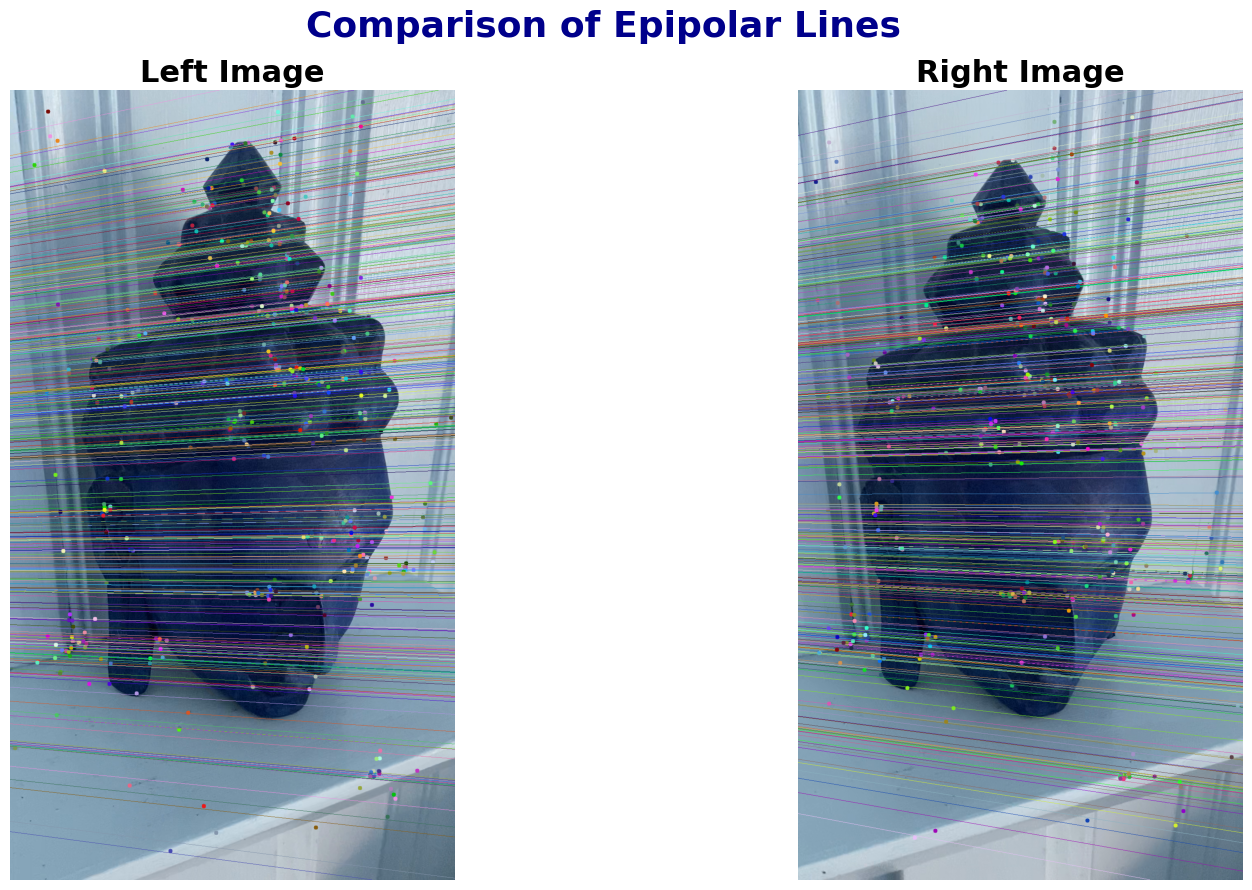

In [8]:
# Initialize lists to store fundamental matrices and inlier points
fundamental_matrices_list = []
inlier_points_list = []

# Iterate through the list of image matches to calculate fundamental matrices
for index in range(len(image) - 1):
    # Check for valid matches before calculating the fundamental matrix
    if matches[index][0].size > 0 and matches[index][1].size > 0:  
        F_matrix, mask, (inliers1, inliers2) = calculate_fundamental_matrix(matches[index][0], matches[index][1])
        # Append the calculated fundamental matrix and inliers to their respective lists
        fundamental_matrices_list.append(F_matrix)
        inlier_points_list.append((inliers1, inliers2))

# Set the index of the images to display epipolar lines
display_index = 7

# Compute the epilines for the left image based on the right image's corresponding points
epilines1 = cv2.computeCorrespondEpilines(matches[display_index][1].reshape(-1, 1, 2), 2, fundamental_matrices_list[display_index])
epilines1 = epilines1.reshape(-1, 3)  # Reshape the epilines for drawing
# Draw the epilines on the left image
img_left, _ = draw_epilines(np.copy(image[display_index]), np.copy(image[display_index + 1]), epilines1, matches[display_index][0], matches[display_index][1])

# Compute the epilines for the right image based on the left image's corresponding points
epilines2 = cv2.computeCorrespondEpilines(matches[display_index][0].reshape(-1, 1, 2), 1, fundamental_matrices_list[display_index])
epilines2 = epilines2.reshape(-1, 3)  # Reshape the epilines for drawing
# Draw the epilines on the right image
img_right, _ = draw_epilines(np.copy(image[display_index + 1]), np.copy(image[display_index]), epilines2, matches[display_index][1], matches[display_index][0])

# Display the annotated images side by side
display_results(img_left, img_right)